# GRAIN ORIENTATION
This Jupyter notebook illustrates the process and functions employed in grain orientation.

### Imports
First of all, make sure all these libraries are installed and can be imported. The python version used is 3.10.13, haven't checked out yet if works for previous versions.

In [1]:
import numpy as np
import pyrender
import trimesh
import os

import math
from copy import copy, deepcopy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from tqdm.notebook import tnrange, tqdm
from ipywidgets import widgets, Layout
from IPython.display import display, clear_output

### Functions
These functions will be used for:
- create and render axis (pyrender)
- compute rotation matrices
- slice meshes
- switch between polar and cartesian coordinates
- align grains over axes
- define pyrender scenes

In [2]:
# --------- Axis ---------
def create_axis_x_mesh(length=5.0, radius=0.02, n_sections=8):
    """
    Creates a cylinder mesh representing the semipositive x-axis.
    
    Parameters:
        length (float | None): Length of the cylinder. Default is 5.0.
        radius (float | None): Radius of the cylinder. Default is 0.02.
        n_sections (int | None): Number of vertices in its bases. Default is 8.
    
    Returns:
        trimesh.Trimesh: Trimesh object representing the semipositive x-axis.
    """
    vertices = []
    faces = []

    # Cylinder top
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = length
        y = radius * np.sin(angle)
        z = radius * np.cos(angle)
        vertices.append([x, y, z])

    # Cylinder bottom
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = 0
        y = radius * np.sin(angle)
        z = radius * np.cos(angle)
        vertices.append([x, y, z])

    # Cylinder faces
    for i in range(n_sections):
        next_i = (i + 1) % n_sections
        faces.append([i, next_i, i + n_sections])
        faces.append([i + n_sections, next_i, next_i + n_sections])

    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces, dtype=np.int32))

def create_axis_y_mesh(length=5.0, radius=0.02, n_sections=8):
    """
    Creates a cylinder mesh representing the semipositive y-axis.
    
    Parameters:
        length (float | None): Length of the cylinder. Default is 5.0.
        radius (float | None): Radius of the cylinder. Default is 0.02.
        n_sections (int | None): Number of vertices in its bases. Default is 8.
    
    Returns:
        trimesh.Trimesh: Trimesh object representing the semipositive y-axis.
    """
    vertices = []
    faces = []

    # Cylinder top
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = length
        z = radius * np.sin(angle)
        vertices.append([x, y, z])

    # Cylinder bottom
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = 0
        z = radius * np.sin(angle)
        vertices.append([x, y, z])

    # Cylinder faces
    for i in range(n_sections):
        next_i = (i + 1) % n_sections
        faces.append([i, next_i, i + n_sections])
        faces.append([i + n_sections, next_i, next_i + n_sections])

    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces, dtype=np.int32))

def create_axis_z_mesh(length=5.0, radius=0.02, n_sections=8):
    """
    Creates a cylinder mesh representing the semipositive z-axis.
    
    Parameters:
        length (float | None): Length of the cylinder. Default is 5.0.
        radius (float | None): Radius of the cylinder. Default is 0.02.
        n_sections (int | None): Number of vertices in its bases. Default is 8.
    
    Returns:
        trimesh.Trimesh: Trimesh object representing the semipositive z-axis.
    """
    vertices = []
    faces = []

    # Cylinder top
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        z = length
        vertices.append([x, y, z])

    # Cylinder bottom
    for i in range(n_sections):
        angle = 2 * np.pi * i / n_sections
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        z = 0
        vertices.append([x, y, z])

    # Cylinder faces
    for i in range(n_sections):
        next_i = (i + 1) % n_sections
        faces.append([i, next_i, i + n_sections])
        faces.append([i + n_sections, next_i, next_i + n_sections])

    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces, dtype=np.int32))

def create_axis(length=5.0, radius=0.02, n_sections=8):
    """
    Creates meshes representing the x, y, and z semipositive axes.
    
    Parameters:
        length (float | None): Length of the cylinders. Default is 5.0.
        radius (float | None): Radius of the cylinders. Default is 0.02.
        n_sections (int | None): Number of vertices in its bases. Default is 8.
    
    Returns:
        Tuple(trimesh.Trimesh, trimesh.Trimesh, trimesh.Trimesh):
            Tuple containing the x, y, and z axis meshes.
    """
    x_axis = create_axis_x_mesh(length, radius, n_sections)
    y_axis = create_axis_y_mesh(length, radius, n_sections)
    z_axis = create_axis_z_mesh(length, radius, n_sections)
    return x_axis, y_axis, z_axis

def render_axis(x_axis, y_axis, z_axis):
    """
    Renders the x, y, and z axis meshes in red, green and blue colors respectively.
    
    Parameters:
        x_axis (trimesh.Trimesh): Mesh representing the x-axis.
        y_axis (trimesh.Trimesh): Mesh representing the y-axis.
        z_axis (trimesh.Trimesh): Mesh representing the z-axis.
    
    Returns:
        Tuple(pyrender.Mesh, pyrender.Mesh, pyrender.Mesh):
            Tuple containing the rendered x, y, and z axis meshes.
    """

    # X axis white
    render_meshx = pyrender.Mesh.from_trimesh(
        x_axis, material=pyrender.MetallicRoughnessMaterial(
        baseColorFactor=[1.0, 0.0, 0.0, 1.0]))
    # Y axis GREEN
    render_meshy = pyrender.Mesh.from_trimesh(
        y_axis, material=pyrender.MetallicRoughnessMaterial(
	    baseColorFactor=[0.0, 1.0, 0.0, 1.0]))
    # Z axis BLUE
    render_meshz = pyrender.Mesh.from_trimesh(
        z_axis, material=pyrender.MetallicRoughnessMaterial(
	    baseColorFactor=[0.0, 0.0, 1.0, 1.0]))
    return render_meshx, render_meshy, render_meshz

# --------- Rotation matrices ---------
def rodrigues_rotation_matrix(omega, theta):
    """
    Computes the rotation matrix of angle theta with respect to the omega axis.
    
    Parameters:
        omega (np.array | List): Rotation axis vector.
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.    
    """
    
    if (isinstance(omega, np.ndarray) and len(omega.shape) == 1
            and omega.shape[0] == 3):
        o_norm = omega/np.linalg.norm(omega)

    elif isinstance(omega, list) and len(omega) == 3:
        o_norm = np.array(omega)
        o_norm = omega/np.linalg.norm(omega)

    o_matrix = np.array([
        [0, -o_norm[2], o_norm[1]],
        [o_norm[2], 0, -o_norm[0]],
        [-o_norm[1], o_norm[0], 0]
    ])
    rotation_matrix = (np.identity(3) + o_matrix * np.sin(theta) +
                       np.matmul(o_matrix, o_matrix) * (1 - np.cos(theta)))
    return rotation_matrix

def x_rotation_matrix(theta):
    """
    Computes the rotation matrix of angle theta with respect to the x axis.
    
    Parameters:
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.
    
    Notes:
        - This function produces slightly less error than rodrigues_rotation_matrix.
    """
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, math.cos(theta), -math.sin(theta)],
        [0, math.sin(theta), math.cos(theta)]
        ])
    return rotation_matrix_x

def y_rotation_matrix(theta):
    """
    Computes the rotation matrix of angle theta with respect to the y axis.
    
    Parameters:
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.
    
    Notes:
        - This function produces slightly less error than rodrigues_rotation_matrix.
    """
    rotation_matrix_y = np.array([
        [math.cos(theta), 0, math.sin(theta)],
        [0, 1, 0],
        [-math.sin(theta), 0, math.cos(theta)]
        ])
    return rotation_matrix_y

def z_rotation_matrix(theta):
    """
    Computes the rotation matrix of angle theta with respect to the z axis.
    
    Parameters:
        theta (float): Angle of rotation in radians.
    
    Returns:
        np.array[3,3]: Rotation matrix.
    
    Notes:
        - This function produces slightly less error than rodrigues_rotation_matrix.
    """
    rotation_matrix_z = np.array([
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1]
        ])
    return rotation_matrix_z

# --------- Section functions ---------
def section(mesh, origin_plane, normal_plane):
    """
    Computes the intersection of a mesh with a given plane.

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array): Origin point of the plane.
        normal_plane (np.array): Normal vector of the plane.

    Returns:
        np.array: Array containing the vertices of the intersection.
    """
    return np.array(mesh.section(plane_origin=origin_plane, plane_normal=normal_plane).vertices)

def xsection(mesh, origin_plane=np.array([0,0,0])):
    """
    Computes the intersection of a mesh with the yz-plane (x-section).

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array, optional): Origin point of the yz-plane. Default is [0,0,0].

    Returns:
        np.array: Array containing the vertices of the intersection in the yz-plane (x-section).
    """
    return section(mesh, origin_plane, np.array([1,0,0]))

def ysection(mesh, origin_plane=np.array([0,0,0])):
    """
    Computes the intersection of a mesh with the xz-plane (y-section).

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array, optional): Origin point of the xz-plane. Default is [0,0,0].

    Returns:
        np.array: Array containing the vertices of the intersection in the xz-plane (y-section).
    """
    return section(mesh, origin_plane, np.array([0,1,0]))

def zsection(mesh, origin_plane=np.array([0,0,0])):
    """
    Computes the intersection of a mesh with the xy-plane (z-section).

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array, optional): Origin point of the xy-plane. Default is [0,0,0].

    Returns:
        np.array: Array containing the vertices of the intersection in the xy-plane (z-section).
    """
    return section(mesh, origin_plane, np.array([0,0,1]))

def plot_xsection(mesh, origin_plane=np.array([0,0,0]), size=2.5):
    """
    Plots the x-section (yz-plane) of a mesh.

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array, optional): Origin point of the yz-plane. Default is [0,0,0].
        size (float, optional): Size of the plot. Default is 2.5.

    Returns:
        None
    """
    section = xsection(mesh, origin_plane=origin_plane)
    y = section[:, 1]
    z = section[:, 2]
    plt.scatter(z, y)
    plt.title(f'Slice x={origin_plane[0]}')
    plt.xlabel('Z Axis')
    plt.ylabel('Y Axis')
    plt.axis('equal')
    plt.xlim([-size,size])
    plt.ylim([-size,size])
    plt.scatter(size, size, color='white', s=0.1)
    plt.scatter(-size, -size, color='white', s=0.1)
    plt.scatter(-size, size, color='white', s=0.1)
    plt.scatter(size, -size, color='white', s=0.1)
    plt.show()
    
def plot_ysection(mesh, origin_plane=np.array([0,0,0]), size=2.5):
    """
    Plots the y-section (xz-plane) of a mesh.

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array, optional): Origin point of the xz-plane. Default is [0,0,0].
        size (float, optional): Size of the plot. Default is 2.5.

    Returns:
        None
    """
    section = ysection(mesh, origin_plane=origin_plane)
    x = section[:, 0]
    z = section[:, 2]
    plt.scatter(z, x)
    plt.title(f'Slice y={origin_plane[1]}')
    plt.xlabel('Z Axis')
    plt.ylabel('X Axis')
    plt.axis('equal')
    plt.xlim([-size,size])
    plt.ylim([-size,size])
    plt.scatter(size, size, color='white', s=0.1)
    plt.scatter(-size, -size, color='white', s=0.1)
    plt.scatter(-size, size, color='white', s=0.1)
    plt.scatter(size, -size, color='white', s=0.1)
    plt.show()

def plot_zsection(mesh, origin_plane=np.array([0,0,0]), size=2.5):
    """
    Plots the z-section (xy-plane) of a mesh.

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.
        origin_plane (np.array, optional): Origin point of the xy-plane. Default is [0,0,0].
        size (float, optional): Size of the plot. Default is 2.5.

    Returns:
        None
    """
    section = zsection(mesh, origin_plane=origin_plane)
    x = section[:, 0]
    y = section[:, 1]
    plt.scatter(x, y)
    plt.title(f'Slice z={origin_plane[2]}')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.axis('equal')
    plt.xlim([-size,size])
    plt.ylim([-size,size])
    plt.scatter(size, size, color='white', s=0.1)
    plt.scatter(-size, -size, color='white', s=0.1)
    plt.scatter(-size, size, color='white', s=0.1)
    plt.scatter(size, -size, color='white', s=0.1)
    plt.show()

def sort_and_roll(x, y):
    """
    Sorts and rolls the input coordinates.

    Parameters:
        x (float): Input x-coordinate.
        y (float): Input y-coordinate.

    Returns:
        Tuple(float, float): Tuple containing the sortes and rolled coordinates.
    """
    # Switch to polar coordinates
    _, theta = polar_coordinates(x, y)
    xx = copy(x)
    yy = copy(y)
    
    # Sort by phase (little disorders in slicing progress)
    sorting_indices = np.argsort(theta)
    sorted_theta = theta[sorting_indices]
    xx = x[sorting_indices]
    yy = y[sorting_indices]
    
    # Roll to start arrays with 0 phase
    arg_min = np.argmin(np.abs(sorted_theta))
    xx = np.roll(xx, -arg_min)
    yy = np.roll(yy, -arg_min)
    return xx, yy

# --------- Polar coordinates ---------
def polar_coordinates(x, y):
    """
    Computes the polar coordinates from Cartesian coordinates.

    Parameters:
        x (np.array): X-coordinates.
        y (np.array): Y-coordinates.

    Returns:
        Tuple[np.array, np.array]: Radius and angle in radians.
    """
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(y, x)
    return r, theta

def cartesian_coordinates_2d(r, theta):
    """
    Computes the Cartesian coordinates from polar coordinates in 2D.

    Parameters:
        r (np.array): Radius.
        theta (np.array): Angle in radians.

    Returns:
        Tuple[np.array, np.array]: X-coordinate and Y-coordinate.
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

# --------- Align functions ---------
def center_mesh(mesh):
    """
    Centers the mesh around its center of mass.

    Parameters:
        mesh (trimesh.Trimesh): Input mesh.

    Returns:
        trimesh.Trimesh: Centered mesh.
    """
    mesh.vertices = mesh.vertices - mesh.center_mass
    return mesh

def align_x(mesh):
    """
    Aligns the grain so that all eigenvectors matches the axis, and the dominant matches the x axis.
    
    Parameters:
        mesh (Trimesh.mesh): Centered mesh of the grain.

    Returns:
        Trimesh.mesh: X-Oriented mesh.
    """
    
    # Principal Component Analysis
    pca = PCA(n_components=3)
    pca.fit(mesh.vertices)
    cov = pca.get_covariance()
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    # Sorting eigenvectors according eigenvalues
    biggest_axis = 0
    ind = np.argmax(eigenvalues)
    if ind != biggest_axis:
        eigenvectors[:, [biggest_axis, ind]] = eigenvectors[:, [ind, biggest_axis]]
        eigenvalues[[biggest_axis, ind]] = eigenvalues[[ind, biggest_axis]]
        mesh.vertices[:, [biggest_axis, ind]] = mesh.vertices[:, [biggest_axis, ind]]

    smallest_axis = 2
    ind = np.argmin(eigenvalues)
    if ind != smallest_axis:
        eigenvectors[:, [smallest_axis, ind]] = eigenvectors[:, [ind, smallest_axis]]
        eigenvalues[[smallest_axis, ind]] = eigenvalues[[ind, smallest_axis]]
        mesh.vertices[:, [biggest_axis, ind]] = mesh.vertices[:, [biggest_axis, ind]]

    # If the sorting produces a negative determinant flip the first eigenvector
    if np.linalg.det(eigenvectors) < 0:
        eigenvectors[:, 0] = -eigenvectors[:, 0]

    mesh.vertices = np.matmul(mesh.vertices, eigenvectors)
    return mesh

def align_y(mesh):
    """
    Aligns the grain along the y-axis by slicing 5 times over the x-axis and computing the nearest point of
    every slice to the origin.
    
    Parameters:
        mesh (Trimesh.mesh): X-oriented mesh.

    Returns:
        Trimesh.mesh: XY-Oriented mesh.
    """
    mesh_copy = deepcopy(mesh)
    correct_orientation = []
    
    # Scale vertices and compute slices
    mesh_copy.vertices /= np.max(np.abs(mesh_copy.vertices[:,0]))/3.5
    xsections = [
        xsection(mesh_copy, origin_plane=np.array([2,0,0])),
        xsection(mesh_copy, origin_plane=np.array([1,0,0])),
        xsection(mesh_copy, origin_plane=np.array([0,0,0])),
        xsection(mesh_copy, origin_plane=np.array([-1,0,0])),
        xsection(mesh_copy, origin_plane=np.array([-2,0,0]))
    ]
    
    # For every section
    for xsec in xsections:
        # Switch to polar coordinates
        radius, theta = polar_coordinates(xsec[:,2], xsec[:,1])
        # Find the lower radius value
        ind = np.argmin(radius)
        r_0 = radius[ind]
        t_0 = theta[ind]
        # Tranform this singular point to cartesian coordinates
        z_0, y_0 = cartesian_coordinates_2d(r_0, t_0)
        if z_0 > 0:
            correct_orientation.append(1)
        else:
            correct_orientation.append(-1)
    
    # Compute the most frequent z coordinate sign for this slices, if negative multiply by a rotation matrix
    if sum(correct_orientation) < 0:
        mesh.vertices = np.matmul(mesh.vertices, x_rotation_matrix(np.pi))
    return mesh

def align_z(mesh):
    """
    Aligns the grain along the z-axis computing the average x coordinate of a z slice.
    
    Parameters:
        mesh (Trimesh.mesh): XY-oriented mesh.

    Returns:
        Trimesh.mesh: XYZ-Oriented mesh.
    """
    zmin = np.min(mesh.vertices[:, 2])
    zmax = np.max(mesh.vertices[:, 2])
    delta = (zmax-zmin)*0.05

    zsec = zsection(mesh, origin_plane=np.array([0, 0, zmin+delta]))
    if np.mean(zsec[:, 0]) < 0:
        mesh.vertices = mesh.vertices = np.matmul(mesh.vertices, z_rotation_matrix(np.pi))
    return mesh

def align(mesh):
    """
    Centers the grain mesh at the origin, aligns it along the x and y axis and tries to align along
    the z axis.
    
    Parameters:
        mesh (Trimesh.mesh): Mesh of the grain.

    Returns:
        Trimesh.mesh: XYZ-Oriented and centered mesh.
    
    Notes:
        - This last z-alignment not always aligns in the desired position (93,4% success),
        so later it has to be checked manually.
    """
    # Centering mesh
    mesh = center_mesh(mesh)
    
    # X and Y alignments
    mesh = align_x(mesh)
    mesh = align_y(mesh)
    mesh = align_z(mesh)

    return mesh

def align_dataset(dataset_path, destination_path=None, widget_flag=False, widget=None):
    """
    Travels recursively through the dataset folder and makes a copy orienting all the stl grains.
    
    Parameters:
        dataset_path (str): Folder path containing the dataset.
        destination_path (None | str): Destination folder path to export the oriented dataset.
        widget_flag (Bool): Activates a widget to see the current path. Default is False.
        widget (None | widget.Text): Widget to see the current path.
    
    Returns:
        None
    """
    # Default name for the new dataset
    if not destination_path:
        destination_path = f"{dataset_path}_ORIENTED"
    
    # Widget to check progress, xor so only executes once
    if widget_flag ^ (widget is not None):
        widget = path_widget(dataset_path)
    
    # List of elements in folder
    elements = os.listdir(dataset_path)
    elements.sort()
    
    for element in elements:
        # Update paths
        path_to_element = f"{dataset_path}/{element}"
        path_to_export = f"{destination_path}/{element}"
        extension = os.path.splitext(path_to_element)[1]
        
        # Display current element path
        if widget:
            widget.value = path_to_element
            
        # Load, align and export mesh
        if extension == ".stl":
            os.makedirs(destination_path, exist_ok=True)
            mesh = trimesh.load(path_to_element)
            mesh = align(mesh)
            mesh.export(path_to_export)
            
        # Recursion over directories
        elif os.path.isdir(path_to_element):
            align_dataset(path_to_element, destination_path=path_to_export, widget_flag=widget_flag, widget=widget)

def path_widget(folder_path):
    """
    Creates a text widget for displaying the current folder path. Useful for
    recursive tours through a dataset.

    Parameters:
        folder_path (str): Folder path.

    Returns:
        widget.Text: Text widget for displaying the current folder path.
    """
    widget = widgets.Text(value=folder_path, description="Current path:", layout=Layout(width='75%'))
    def update_path(change):
        clear_output(wait=True)
        display(widget)
    widget.observe(update_path, names='value')
    return widget

# --------- Pyrender ---------
def lookAt(eye, target, up, yz_flip=False):
    """
    Computes the camera pose matrix based on the eye, target, and up vectors.

    Parameters:
        eye (np.array): Position of the camera.
        target (np.array): Position of the target.
        up (np.array): Up vector.
        yz_flip (bool, optional): Flag to flip y and z axes. Default is False.

    Returns:
        np.array: Camera pose matrix.
    """
    # copied from https://github.com/Jianghanxiao/Helper3D/tree/master/trimesh_render
    # Normalize the up vector
    up /= np.linalg.norm(up)
    forward = eye - target
    forward /= np.linalg.norm(forward)
    if np.dot(forward, up) == 1 or np.dot(forward, up) == -1:
        up = np.array([0.0, 1.0, 0.0])
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    new_up = np.cross(forward, right)
    new_up /= np.linalg.norm(new_up)

    # Construct a rotation matrix from the right, new_up, and forward vectors
    rotation = np.eye(4)
    rotation[:3, :3] = np.row_stack((right, new_up, forward))

    # Apply a translation to the camera position
    translation = np.eye(4)
    translation[:3, 3] = [
        np.dot(right, eye),
        np.dot(new_up, eye),
        -np.dot(forward, eye),
    ]

    if yz_flip:
        # This is for different camera setting, like Open3D
        rotation[1, :] *= -1
        rotation[2, :] *= -1
        translation[1, 3] *= -1
        translation[2, 3] *= -1

    camera_pose = np.linalg.inv(np.matmul(translation, rotation))

    return camera_pose

def render_folder(folder_path, scene, n_rows, x_separation=10, y_separation=4):
    """
    Renders all .stl files of the given folder and adds them to the scene.
    
    Parameters:
        folder_path (str): folder path containing the grains.
        scene (pyrender.scene.Scene): scene where meshes are displayed.
        n_rows (int): number of rows of the display.
        x_separation (int): distance added to separate in x axis.
        y_separation (int): distance added to separate in y axis.
    
    Returns:
        None
    """
    # Listing folder contents
    paths = os.listdir(folder_path)
    paths.sort()
    
    # For every element
    for i, path in enumerate(paths):
        import_path = folder_path + "/" + path
        # If the element is a stl mesh
        if path[-3:] == "stl":
            mesh = trimesh.load(import_path)
            # Arrange grains in a tabular distribution
            mesh.vertices = mesh.vertices + np.array([x_separation * (i // n_rows), y_separation * (i % n_rows), 0])
            render_mesh = pyrender.Mesh.from_trimesh(mesh)
            scene.add(render_mesh)

def scene_from_folder(folder_path, n_rows, x_separation=10, y_separation=4):
    """
    Creates a scene with axis, camera, light and all the grains
    of the given folder.
    
    Parameters:
        folder_path (str): folder path containing the grains.
        n_rows (int): number of rows of the display.
        x_separation (int): distance added to separate in x axis.
        y_separation (int): distance added to separate in y axis.
    
    Returns:
        scene (pyrender.scene.Scene): scene where meshes are displayed.
    """
    scene = pyrender.Scene()
    x_axis, y_axis, z_axis = create_axis(length=4.0, radius=0.05)
    render_x_axis, render_y_axis, render_z_axis = render_axis(x_axis, y_axis, z_axis)
    scene.add(render_x_axis)
    scene.add(render_y_axis)
    scene.add(render_z_axis)

    render_folder(folder_path, scene, n_rows)
    # CAMERA AND LIGHT
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    light = pyrender.PointLight(intensity=10.0)

    scene.add(camera, pose=np.eye(4))
    scene.add(light, pose=np.eye(4))
    return scene

def scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=False):
    """
    Creates a custom scene with a mesh, camera, and light.

    Parameters:
        mesh (Trimesh.mesh): Mesh to be rendered.
        camera_eye (np.array): Position of the camera.
        camera_target (np.array): Position of the target.
        camera_up (np.array): Up vector.
        axis_flag (bool, optional): Flag to include axis in the scene. Default is False.

    Returns:
        pyrender.Scene: Custom scene.
    """
    scene = pyrender.Scene()

    if axis_flag:
        x_axis, y_axis, z_axis = create_axis(length=4.0, radius=0.05)
        render_x_axis, render_y_axis, render_z_axis = render_axis(x_axis, y_axis, z_axis)
        scene.add(render_x_axis)
        scene.add(render_y_axis)
        scene.add(render_z_axis)
    
    render_mesh = pyrender.Mesh.from_trimesh(mesh)
    scene.add(render_mesh)
    camera_pose = lookAt(camera_eye, camera_target, camera_up, yz_flip=False)
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    scene.add(camera, pose=camera_pose)

    light = pyrender.PointLight(intensity=50.0)
    scene.add(light, pose=camera_pose)
    return scene

def grain_sheet(mesh_path, save_path=None):
    """
    Displays a grain sheet with different perspectives and slices.

    Parameters:
        mesh_path (str): Path to the grain mesh.
        save_path (None | str): Path to save the grain sheet. It has to include the desired extension.
    
    Returns:
        None
    """
    # Renderer
    viewport_width = 640
    viewport_height = 480
    renderer = pyrender.OffscreenRenderer(viewport_width=viewport_width, viewport_height=viewport_height, point_size=1.0)
    
    # Loading mesh
    mesh = trimesh.load(mesh_path)
    
    # Axis
    axis_flag = True

    # XYZ scene
    camera_eye = np.array([4,4,4], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_xyz = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_xyz, _ = renderer.render(scene_xyz)

    # Positive Z scene
    camera_eye = np.array([0,0,6], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_z_pos = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_z_pos, _ = renderer.render(scene_z_pos)

    # Negative Z scene
    camera_eye = np.array([0,0,-6], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_z_neg = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_z_neg, _ = renderer.render(scene_z_neg)

    # Positive X scene
    camera_eye = np.array([6,0,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_x_pos = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_x_pos, _ = renderer.render(scene_x_pos)

    # Negative X scene
    camera_eye = np.array([-6,0,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_x_neg = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_x_neg, _ = renderer.render(scene_x_neg)

    # Positive Y scene
    camera_eye = np.array([0,6,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,0,1], dtype=np.float64)

    scene_y_pos = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_y_pos, _ = renderer.render(scene_y_pos)

    # Negative Y scene
    camera_eye = np.array([0,-6,0], dtype=np.float64)
    camera_target = np.array([0,0,0], dtype=np.float64)
    camera_up = np.array([0,0,1], dtype=np.float64)

    scene_y_neg = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_y_neg, _ = renderer.render(scene_y_neg)

    # Void scene
    camera_eye = np.array([50,0,0], dtype=np.float64)
    camera_target = np.array([60,0,0], dtype=np.float64)
    camera_up = np.array([0,1,0], dtype=np.float64)

    scene_void = scene_from_mesh(mesh, camera_eye, camera_target, camera_up, axis_flag=axis_flag)
    color_void, _ = renderer.render(scene_void)

    # X section
    xsec = xsection(mesh)
    y = xsec[:, 1]
    z = xsec[:, 2]
    xsec_y, xsec_z = sort_and_roll(y, z)

    # Y section
    ysec = ysection(mesh)
    x = ysec[:, 0]
    z = ysec[:, 2]
    ysec_x, ysec_z = sort_and_roll(x, z)

    # Z section
    zsec = zsection(mesh)
    x = zsec[:, 0]
    y = zsec[:, 1]
    zsec_x, zsec_y = sort_and_roll(x, y)

    # Plot
    fig, axs = plt.subplots(6, 2, constrained_layout=True, figsize=(15,28))

    # Name + void scene
    grain_name = os.path.splitext(os.path.basename(mesh_path))[0]
    axs[0, 0].imshow(color_void)
    axs[0, 0].text(0.5*viewport_width, 0.5*viewport_height, grain_name, size=40, rotation=0.,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
            )
    
    # Void scene
    axs[0, 1].imshow(color_void)
    
    # Positive X scene
    axs[1, 0].imshow(color_x_pos)
    axs[1, 0].set_title('+X VIEW')

    # Negative X scene
    axs[1, 1].imshow(color_x_neg)
    axs[1, 1].set_title('-X VIEW')
    
    # Positive Y scene
    axs[2, 0].imshow(color_y_pos)
    axs[2, 0].set_title('+Y VIEW')
    
    # Negative Y scene
    axs[2, 1].imshow(color_y_neg)
    axs[2, 1].set_title('-Y VIEW')
    
    # Positive Z scene
    axs[3, 0].imshow(color_z_pos)
    axs[3, 0].set_title('+Z VIEW')
    
    # Negative Z scene
    axs[3, 1].imshow(color_z_neg)
    axs[3, 1].set_title('-Z VIEW')
    
    # XYZ scene
    axs[4, 0].imshow(color_xyz)
    axs[4, 0].set_title('+XYZ VIEW')
    axs[4, 0].axis('off')
    
    # X section
    axs[4, 1].plot(xsec_z, xsec_y)
    axs[4, 1].set_title('X=0 SECTION')
    axs[4, 1].set_xlabel('Z COORDINATE')
    axs[4, 1].set_ylabel('Y COORDINATE')

    # Y section
    axs[5, 0].plot(ysec_x, ysec_z)
    axs[5, 0].set_title('Y=0 SECTION')
    axs[5, 0].set_xlabel('X COORDINATE')
    axs[5, 0].set_ylabel('Z COORDINATE')

    # Z section
    axs[5, 1].plot(zsec_x, zsec_y)
    axs[5, 1].set_title('Z=0 SECTION')
    axs[5, 1].set_xlabel('X COORDINATE')
    axs[5, 1].set_ylabel('Y COORDINATE')

    # Deleting axis for projections, not slices
    for i in range(4):
        for j in range(2):
            axs[i, j].axis('off')
    
    # Setting aspect ratios
    for i in range(4, 6):
        for j in range(2):
            axs[i, j].set_aspect(1, adjustable='box')

    # Save plot
    if save_path:
        plt.savefig(save_path)

    # Show plot
    plt.show()
    
    # Delete offscreen renderer, if don't next call to this function raises an exception
    del renderer

In [4]:
# folder_path = "../../../../data/unoriented_dataset/Barley STL files/Dundee/2ROW British"
folder_path = "./data/6ROW Scandinavian"
scene = scene_from_folder(folder_path, n_rows=5, x_separation=10, y_separation=5)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, all_wireframe=False)

### Step-by-step orientation
Let's import a mesh from our dataset and plot it.

In [4]:
# Load mesh
mesh_path = "./data/unoriented_dataset/Dundee/6ROW Bere/6ROW BERE Unknown/DHBT16P4 10.stl"
mesh = trimesh.load(mesh_path)
print(mesh.center_mass)

# Create axes in the cartesian origin
x_axis, y_axis, z_axis = create_axis(length=5.0, radius=0.05)

# Create and show a scene containing the mesh and the axes
scene = trimesh.Scene([mesh, x_axis, y_axis, z_axis])
scene.show()

[ 1.8804617   2.19114109 35.24076929]


As you can see this grain is neither centered nor oriented. To align a grain we just have to call the **align** function with a mesh as a parameter.

In [4]:
# Align mesh
aligned_mesh = deepcopy(mesh)
aligned_mesh = align(aligned_mesh)

# Create and show a scene containing the mesh and the axes
aligned_scene = trimesh.Scene([aligned_mesh, x_axis, y_axis, z_axis])
aligned_scene.show()

This seems simple, but let's see how **align** deals with every axis alignment.

The first alignment to do is along the x axis. Starts with a PCA of the vertices and compute the eigenvalues and eigenvectors. The alignment consists on orienting the grain in a form such that the eigenvector of dominant eigenvalue (the one with higher absolut value) matches the x axis. To do this multiply the vertices with the matrix of eigenvectors, where the first eigenvector is the dominant one.

Let V be the vertices matrix and H the eigenvector matrix, then the new vertices  $V' = V\cdot H$

In [5]:
mesh_x = deepcopy(mesh)
mesh_x = center_mesh(mesh_x)
mesh_x = align_x(mesh_x)

# Create and show a scene containing the mesh and the axes
x_scene = trimesh.Scene([mesh_x, x_axis, y_axis, z_axis])
x_scene.show()

The previous alignment makes all eigenvectors match axis, and the dominant one the x axis. This means the left y and z alignments consist on rotations of angle $\pi$.

The y alignment is based on the shape of $x=constant$ slices. As you can see, there's a groove that can be used as a reference since is a singular point in this slice. This singular point can be found by transforming the slice points into polar coordinates and taking the angle of the lowest radius.

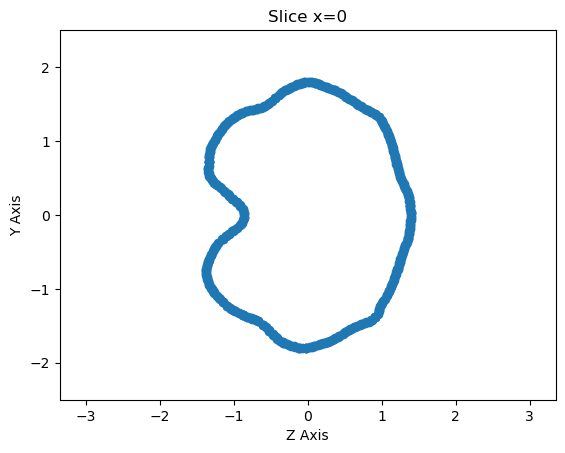

In [6]:
plot_xsection(mesh_x)

This method needs to be refined since is susceptible to noise on the grain surface. That's why the alignment consists of 5 slices $x = k$ for $k\in[-2,-1,0,1,2]$. Proceed by finding each singular point for every slice and counting how many of them have their $z$ component positive. If there are more positive points than negative there's no need to align, otherwise, multiply the vertices by a $x$ rotation matrix of angle $\pi$.

$V' = V\cdot R_x(\pi)$



In [7]:
mesh_y = deepcopy(mesh_x)
mesh_y = align_y(mesh_y)

# Create and show a scene containing the mesh and the axes
y_scene = trimesh.Scene([mesh_y, x_axis, y_axis, z_axis])
y_scene.show()

The last alignment is over the z axis. It is based on the belly of the grains on the opposite side of the groove. If you slice this belly almost at the edge of the grain you will see that it is slightly shifted respect the line $x=0$. We can take advantage of this by averaging this belly slice and rotating if the x coordinate is negative.

-1.387352666079445


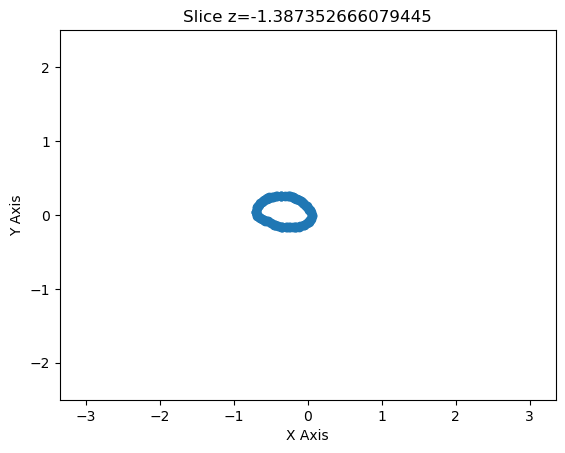

In [8]:
zmin = np.min(mesh_y.vertices[:, 2])
zmax = np.max(mesh_y.vertices[:, 2])
delta = (zmax-zmin)*0.01
print(zmin + delta)
plot_zsection(mesh_y, origin_plane=np.array([0, 0, zmin+delta]))

In [9]:
mesh_z = deepcopy(mesh_y)
mesh_z = align_z(mesh_z)

# Create and show a scene containing the mesh and the axes
z_scene = trimesh.Scene([mesh_z, x_axis, y_axis, z_axis])
z_scene.show()

### Aligning a dataset

Now that we know how to align a grain, it's time to align a whole dataset. To do this we're going to use the **align_dataset** function defined before. This function will walk through the entire dataset, copy its folder structure and save there the oriented grains, so the original data will remain unchanged. Files that are neither folders nor stl meshes will be ignored.

In [10]:
# Dataset path
dataset_path = "./data/unoriented_dataset"

# Align dataset
align_dataset(dataset_path, widget_flag=True)

Text(value='./data/unoriented_dataset/Orkney/6ROW Scandinavian/OBT16P33 7.stl', description='Current path:', l…

As mentioned before, z-alignment not always aligns in the desired position, so later it has to be checked manually which grains are not well oriented.

Instead of plotting one grain after another and checking if it's in the right orientation, we'll plot grains by folders and display them in columns. This way we can write down the rows and columns of the problematic grains and fix them.

To demonstrate this we're going to use the folder **./data/unoriented_dataset_ORIENTED/Orkney/6ROW Bere/6ROW BERE ORKNEY**. A pyrender window will display the grains in this folder and, as you will see, grains in column 2 and rows 8 and 9 won't be well z-rotated. Remark that the first column and the first row start at 0, so the second column mentioned before would be the third if we start counting at 1.

In [6]:
# folder_path = './data/unoriented_dataset_ORIENTED/Orkney/6ROW Bere/6ROW BERE ORKNEY'
folder_path = "../../../../data/unoriented_dataset_ORIENTED/Barley STL files/Dundee/2ROW British"
n_rows = 10

# Scene
scene = scene_from_folder(folder_path, n_rows)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, all_wireframe=False)

Now we write down the columns and rows of the grains to be fixed in the rotate_pairs list following this format: (column, row).

In [12]:
rotate_pairs = [(2, 8), (2, 9)]
# Indices in folder paths list
rotate_list = [col * n_rows + row for (col, row) in rotate_pairs]

In [13]:
# Listing paths
paths = os.listdir(folder_path)
paths.sort()

# For every grain to be fixed
for i in rotate_list:
    # Load
    mesh = trimesh.load(folder_path + "/" + paths[i])
    # Fix
    mesh.vertices = mesh.vertices = np.matmul(mesh.vertices, z_rotation_matrix(np.pi))
    # Export
    mesh.export(folder_path + "/" + paths[i])

As you can see, all grains are well oriented.

In [14]:
# Scene
scene = scene_from_folder(folder_path, n_rows)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, all_wireframe=False)

## Offscreen rendering
Also we've coded a tool to generate a grain sheet plotting the grain from different perspectives. It only needs the path to the grain.

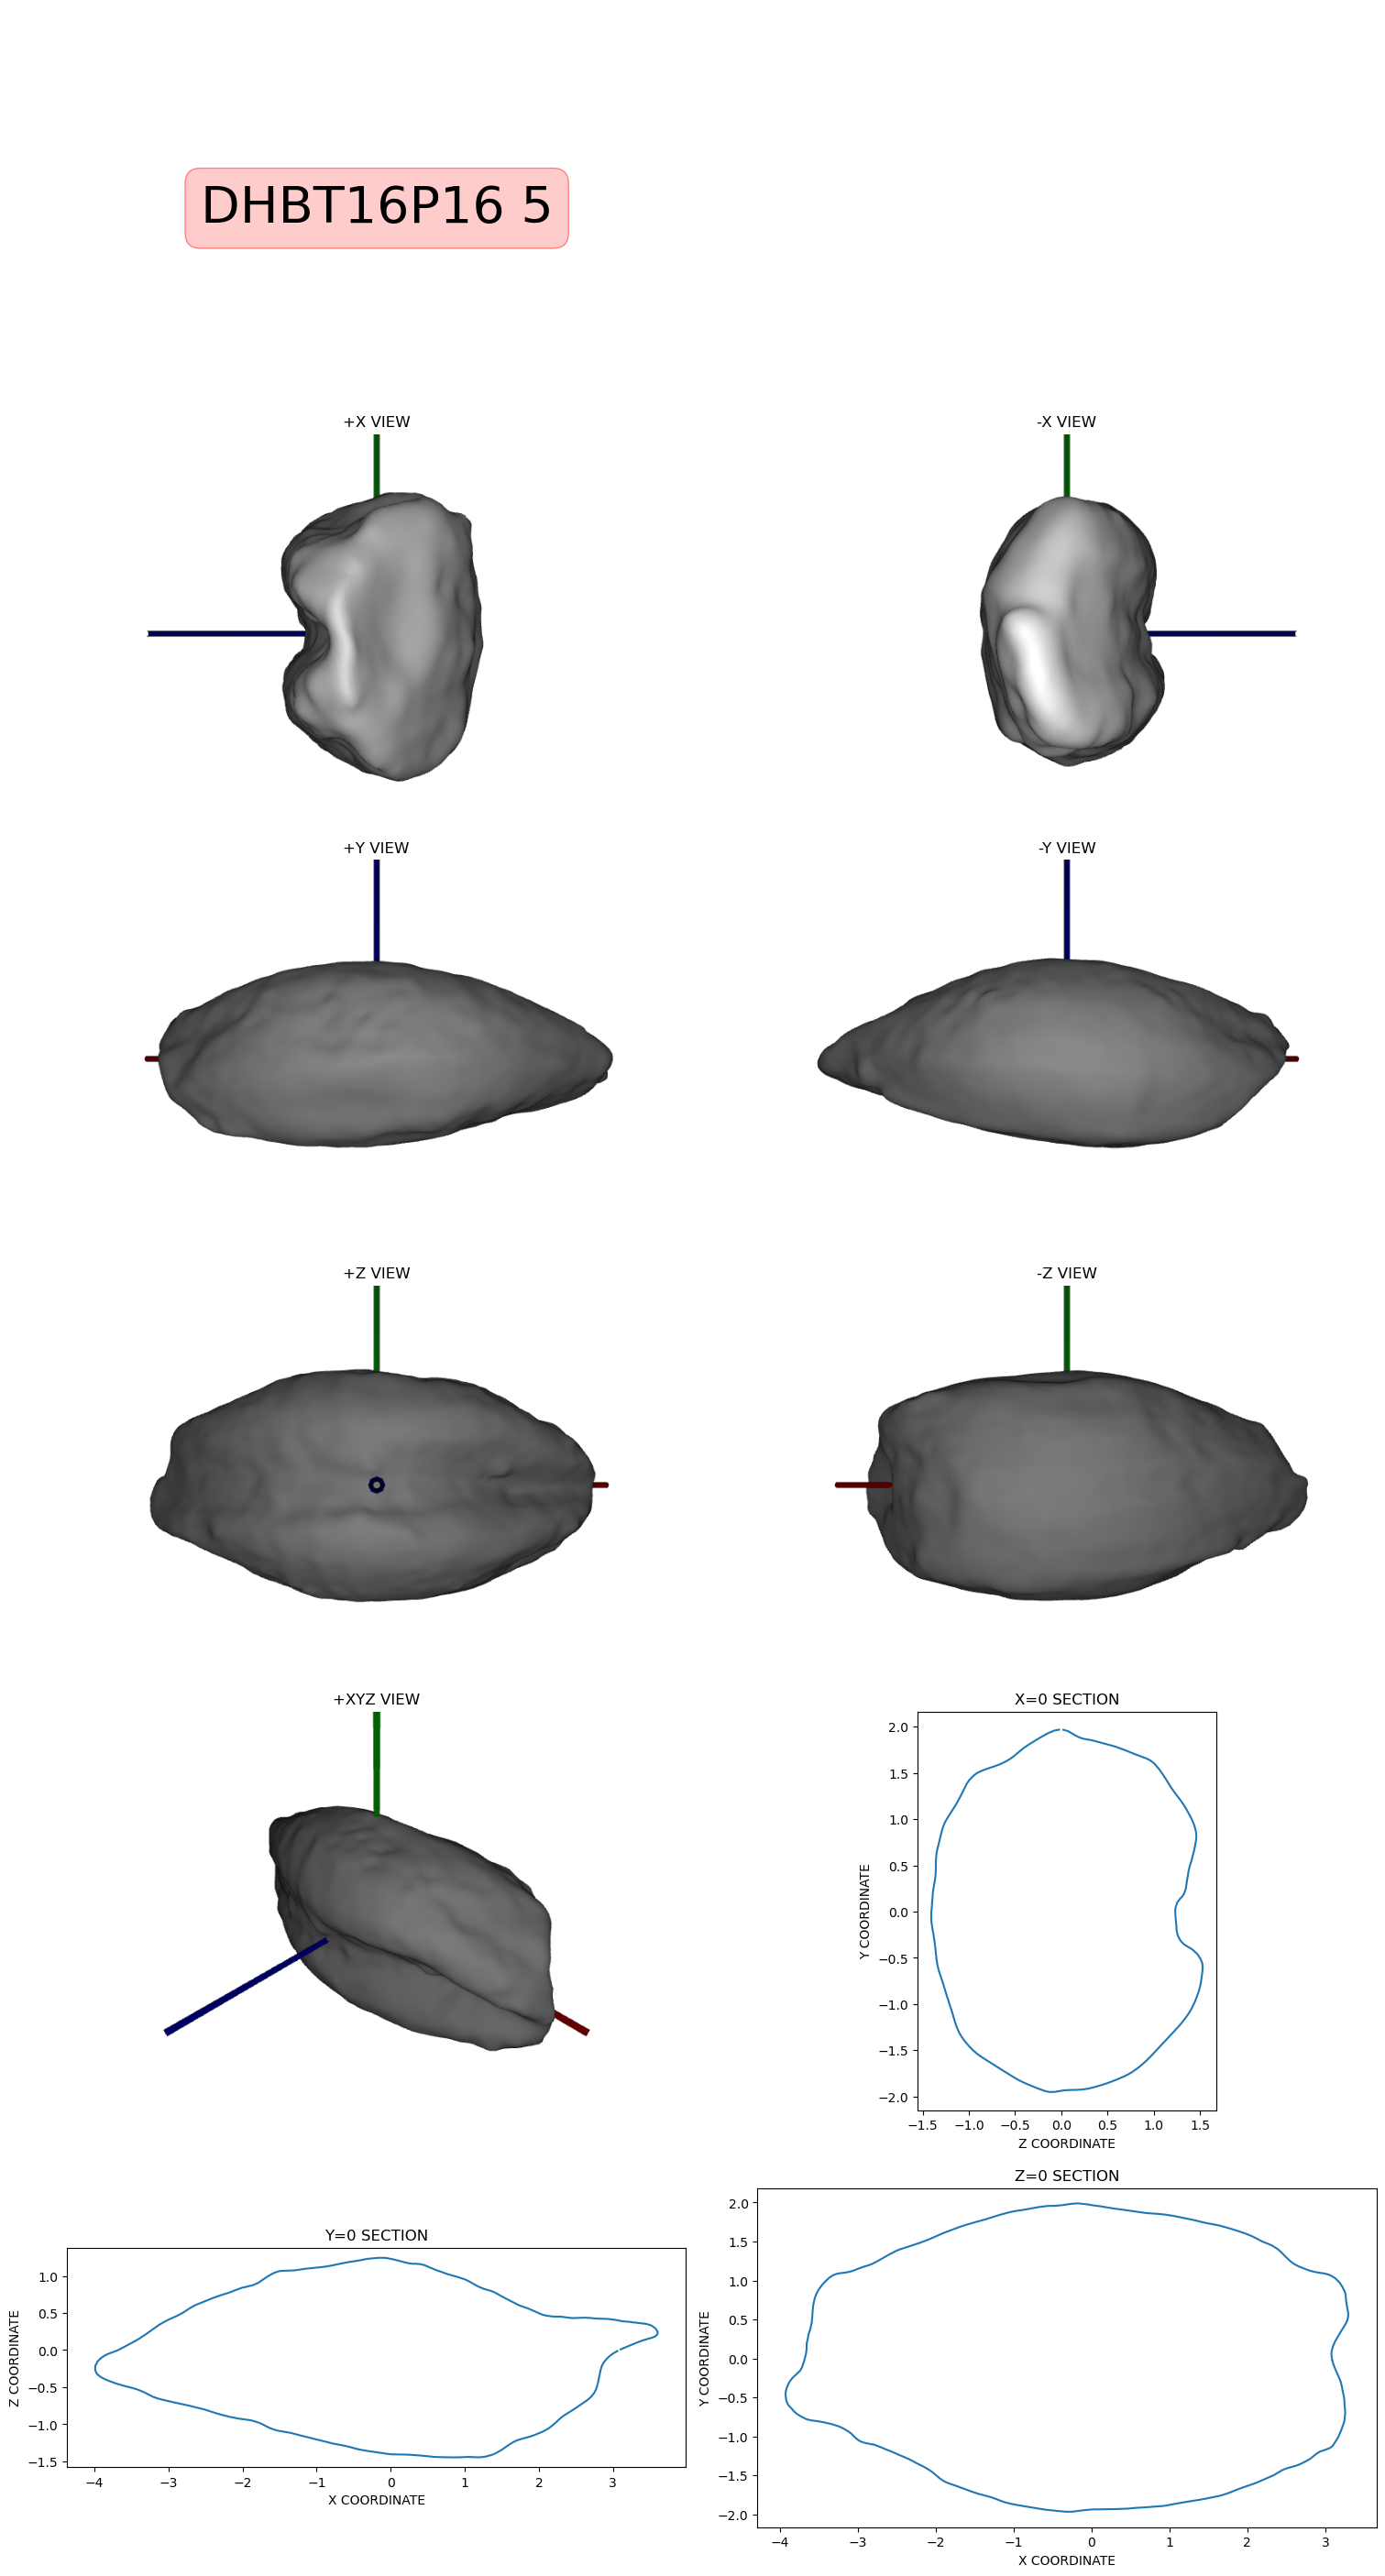

In [15]:
grain_sheet_mesh_path = "./data/unoriented_dataset_ORIENTED/Dundee/2ROW British/DHBT16P16 5.stl"
save_path = "./data/data_sheet_example.png"
grain_sheet(grain_sheet_mesh_path, save_path=save_path)